In [ ]:
# def colab_download(proj_name,is_kaggle):
#     import requests
#     from tqdm import tqdm
#
#     if is_kaggle:
#         import sys
#         sys.path.append("/kaggle/working/")
#
#     project_name=proj_name
#
#     url = f'http://kuroweb.tk:8000/api/v1/pack/wyftp/dataset/{project_name}.tar.gz'
#     user, password = 'wuying', '123aaa'
#     response = requests.get(url, stream=True,auth=(user, password))
#     total_size_in_bytes= int(response.headers.get('content-length', 0))
#     block_size = 1024 #1 Kibibyte
#     progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
#     with open('download.tar.gz', 'wb') as file:
#         for data in response.iter_content(block_size):
#             progress_bar.update(len(data))
#             file.write(data)
#     progress_bar.close()
#     if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
#         print("ERROR, something went wrong")
#
#     import tarfile
#
#     # open file
#     file = tarfile.open('download.tar.gz')
#     # extracting file
#     file.extractall('./')
#     file.close()
#
#     import shutil
#     import os
#
#     source_dir = f'./{project_name}'
#     target_dir = './'
#
#     file_names = os.listdir(source_dir)
#
#     for file_name in file_names:
#         try:
#             shutil.move(os.path.join(source_dir, file_name), target_dir)
#         except Exception as e:
#             print(e,'at',file_name)
#
# colab_download('model',True)
#
# !pip install -r requirements.txt

In [48]:
import time
!pip --version
import os
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklite import LazyExport


import json

import numpy as np
import seaborn as sns

# record start time
import pandas as pd
import torch
from IPython.core.display import display
from keras import layers
# residual block
# https://stackoverflow.com/questions/64792460/how-to-code-a-residual-block-using-two-layers-of-a-basic-cnn-algorithm-built-wit
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from general_model.grow_numpy import GrowableNumpyArray
from general_model.list_batch_loader import ListBatchLoadDataset
from model_helper.single_gpu_dataloader import SingleGpuTensorWrapper
from pytorch_regression.regression_params import RegressionParams
from tool import ml, wine_tool, data_loader, wine_data_loader
from tool.dbg import dbg

pip 22.0.3 from D:\miniconda\envs\tf_gpu\lib\site-packages\pip (python 3.7)



In [49]:
x_all_pre, y_all_pre = wine_data_loader.get_data3(use_onehot=False)
x_all_pre.shape


(740, 1000)

# Agumented data

In [50]:
import random


def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

class WineDataAugmentation:
    def __init__(self, xs: np.array, ys: np.array):
        self.xs = xs
        self.ys = ys


    def generate(self, size=2):
        new_size = self.xs.shape[0] * size
        # numpy拷贝xs和ys到size倍

        xs=np.repeat(self.xs, size, axis=0)
        ys=np.repeat(self.ys, size, axis=0)

        # xs [batch * 1000]
        # 对xs中的第一个维度随机乘以0.1-1.0之间的数
        xs = xs * np.random.uniform(0.9, 1.1, size=(new_size, 1))

        # 加入-300~300的噪音
        # noise = np.random.random((new_size, self.xs.shape[1]))
        # noise = noise * 10000
        # print(noise)
        # print(np.ptp(noise, axis=1).shape)
        # print(np.ptp(noise, axis=1))
        # return
        # xs = xs + noise
        # # 每个样本减去自己的最小值
        # xs = xs - np.min(xs, axis=1).reshape(-1, 1)
        dbg(xs.shape)

        for i in range(xs.shape[0]):
            this_tensor=xs[i]
            # r= random [-200,200]
            r=random.randint(-50,50)
            # r=random.randint(-500,500)
            # dbg(r)
            if r<0:
                r=-r
                xs[i][:1000-r]=this_tensor[r:1000]
                xs[i][1000-r:]=this_tensor[1000-r-1]
            else:
                xs[i][r:1000]=this_tensor[:1000-r]
                xs[i][:r]=this_tensor[r]
        # xs=xs[0:50]
        # xs=xs[50:100]
        # xs=xs[0:100]
        # dbg('0',xs[:,:5])
        # xs=shuffle_along_axis(xs, axis=0)
        # dbg('1',xs[:,:5])
        return xs, ys

In [51]:
x_all_augmented,y_all_augmented = WineDataAugmentation(x_all_pre,y_all_pre).generate(5)
x_all_augmented.shape

(3700, 1000)


(3700, 1000)

In [52]:
x_all_augmented = x_all_augmented.astype(np.float32)
y_all_augmented = y_all_augmented.astype(np.float32)

In [53]:
import time
from collections import OrderedDict

import torch.nn as nn
# import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

import random

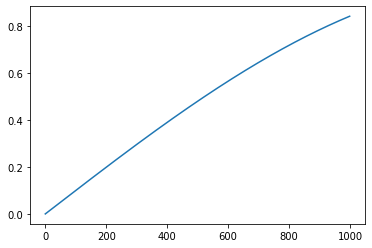

In [54]:
test_pe = (torch.sin(torch.arange(0, 1, 0.001))).unsqueeze(1)

plt.plot(test_pe)
plt.show()

In [55]:
def dbg(*args, sep=' ', **kwargs):
    if kwargs.__contains__('force'):
        if kwargs['force']:
            del kwargs['force']
            print(*args, sep=sep, **kwargs)
        return

    if True:
        # if False:
        print(*args, sep=sep, **kwargs)

In [56]:

use_cpu = False
# use_cpu = True

steps = np.linspace(0, np.pi * 2, 1000, dtype=np.float)  # float32 for converting torch FloatTensor

# y_np = np.cos(2 * steps)

# add some importance to range of values
# y_np[10:20] += np.random.uniform(-2, 2, size=10)

# y_np_target = np.cos(2 * steps + np.pi / 2)
# y_np_target = np.cos(2 * steps + np.pi / 2)
# y_np_target=np.zeros(y_np.shape)
# y_np_target[400:600]+=np.sin(2 * steps[400:600]*1.1 + np.pi / 2)/1.2

y_np=x_all_augmented
y_np_target=y_all_augmented

x = torch.from_numpy(steps[:, np.newaxis]).float() if use_cpu else torch.from_numpy(
    steps[:, np.newaxis]).float().cuda()  # shape (1000, 1)

y = torch.from_numpy(y_np[:, np.newaxis]).float() if use_cpu else torch.from_numpy(
    y_np[:, np.newaxis]).float().cuda()

x.shape, y.shape

D:\miniconda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


(torch.Size([1000, 1]), torch.Size([3700, 1, 1000]))

In [79]:
x=torch.from_numpy(x_all_augmented) if use_cpu else torch.from_numpy(x_all_augmented).cuda()
x/=np.max(x_all_augmented)
y=torch.from_numpy(y_all_augmented) if use_cpu else torch.from_numpy(y_all_augmented).cuda()
y=x

In [80]:
x.shape,y.shape

(torch.Size([3700, 1000]), torch.Size([3700, 1000]))

In [81]:
# y是曲线对应位置的强度 target_torch是标签
# y_np_torch=x[:50].reshape(-1,1000,1)
# y_np_target_torch=y[:50].reshape(-1,1000,1)
y_np_torch=x[:].reshape(-1,1000,1)
y_np_target_torch=y[:].reshape(-1,1000,1)

In [82]:
y_np_torch.shape,y_np_target_torch.shape


(torch.Size([3700, 1000, 1]), torch.Size([3700, 1000, 1]))

In [83]:
y_np_torch_override=y_np_torch
y_np_target_torch_override=y_np_target_torch
y_np_torch_override.shape,y_np_target_torch_override.shape,

(torch.Size([3700, 1000, 1]), torch.Size([3700, 1000, 1]))

In [61]:
# y_np_torch = torch.from_numpy(y_np[:, np.newaxis]).float() if use_cpu else torch.from_numpy(
#     y_np[:, np.newaxis]).float().cuda()  # shape (1000, 1)
# dbg(x.dtype)
# y_np_target_torch = torch.from_numpy(y_np_target[:, np.newaxis]).float() if use_cpu else torch.from_numpy(
#     y_np_target[:, np.newaxis]).float().cuda()
#
# # y_np_torch = y_np_torch.unsqueeze(0).repeat(32, 1, 1)
# y_np_torch = y_np_torch.unsqueeze(0)
# # add uniform noise to y_np_torch
# # y_np_torch += torch.randn(y_np_torch.shape).cuda() * 0.1
#
# # y_np_target_torch = y_np_target_torch.unsqueeze(0).repeat(32,1,1)
# y_np_target_torch = y_np_target_torch.unsqueeze(0)
# y_np_torch.shape, y_np_target_torch.shape

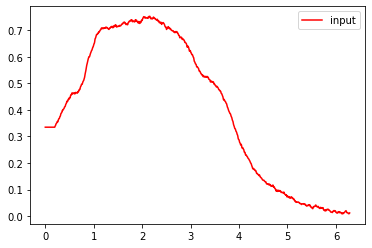

In [84]:
plt.plot(steps, y_np_torch[0].detach().cpu().numpy(), 'r-',label='input')

# plt.plot(steps, y_np_target[0], 'b-',label='target')
plt.legend()
plt.show()



In [85]:
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        # dbg('LambdaLayer', x.shape)
        return self.lambd(x)


class Attention(nn.Module):

    def __init__(self, dmodel):
        super().__init__()
        self.dmodel = dmodel
        self.max_len = 1000
        # self.feature = nn.Linear(1, self.dmodel, bias=False)
        self.qkv_linear = nn.ModuleList(
            [torch.nn.Linear(self.dmodel, self.dmodel, bias=False) for _ in range(3)]
        )
        self.final_linear1 = torch.nn.Linear(self.dmodel, self.dmodel, bias=False)
        self.final_activation = torch.nn.Sigmoid()
        self.final_linear2 = torch.nn.Linear(self.dmodel, self.dmodel, bias=False)

        pe = (torch.sin(torch.arange(0, 1, 0.001))).unsqueeze(1)
        # pe=(torch.sin(torch.arange(0,500,5))).unsqueeze(1)
        # self.pe=torch.nn.Parameter(pe,requires_grad=False)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # dbg('input', x.shape)
        # x=self.feature(x+self.pe)
        q = self.qkv_linear[0](x)
        k = self.qkv_linear[1](x)
        v = self.qkv_linear[2](x)
        # dbg(q.shape,k.shape,v.shape,k.T.shape)

        attention_pre = torch.bmm(q, torch.transpose(k, -1, -2))
        attention = torch.softmax(attention_pre, dim=2)

        output = torch.bmm(attention, v)
        # dbg(torch.softmax(torch.bmm(q , torch.transpose(k,1,2)),dim=2)[0,0,:].sum())
        # dbg(output.shape,torch.bmm(q , torch.transpose(k,1,2)).shape)
        final_linear1_output = self.final_linear1(output)
        final_activation_output = self.final_activation(final_linear1_output)
        final_linear2_output = self.final_linear2(final_activation_output)

        return final_linear2_output,attention


class Encoder(nn.Module):
    def __init__(self, dmodel,attention_layer=1):
        super().__init__()
        self.dmodel = dmodel
        self.attention_layer=attention_layer
        self.feature = nn.Linear(1, self.dmodel, bias=True)
        # self.feature_activation = nn.Tanh()
        self.attentions = nn.ModuleList(
            [Attention(self.dmodel) for _ in range(self.attention_layer)]
        )

        pe = (torch.sin(torch.arange(0, self.dmodel, 0.001))).reshape(1,1000,self.dmodel)
        # pe=(torch.sin(torch.arange(0,500,5))).unsqueeze(1)
        # self.pe=torch.nn.Parameter(pe,requires_grad=False)
        self.register_buffer('pe', pe)
        self.output_pre=nn.Linear(self.dmodel,self.dmodel)
        self.output_activation=nn.Sigmoid()
        self.output_feature=nn.Linear(self.dmodel,1,bias=False)


    def forward(self, x):
        # dbg('input', x.shape)
        features = self.feature(x)
        # features = self.feature_activation(features)
        # dbg('features', features.shape)
        features = features + self.pe

        last_attention=None

        for attention in self.attentions:
            features,last_attention = attention(features)

        # dbg(features.shape,self.pe.shape,'f')

        output_pre=self.output_pre(features)
        output_activation=self.output_activation(output_pre)
        features = self.output_feature(output_activation)

        return features,last_attention

In [87]:
# lazyloader
dbg(y_np_target_torch_override.shape)
from torch.utils.data import Dataset, DataLoader

class LazyLoadDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self):
        pass

    def __len__(self):
        return len(y_np_target_torch_override)

    def __getitem__(self, idx):
        # dbg('idx',idx)
        return y_np_torch_override[idx],y_np_target_torch_override[idx]



curve_dataset = LazyLoadDataset()
dataloader = DataLoader(curve_dataset, batch_size=16,
                            shuffle=True, num_workers=0)

torch.Size([3700, 1000, 1])


In [100]:
loss_func = nn.MSELoss()

m = Encoder(dmodel=2)
# m = Encoder(dmodel=3)
# m = Encoder(dmodel=1)
m = m if use_cpu else m.cuda()
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)

# optimize all cnn parameters



In [101]:
# for d1,d2 in dataloader:
#     dbg('s',d1.shape,d2.shape)

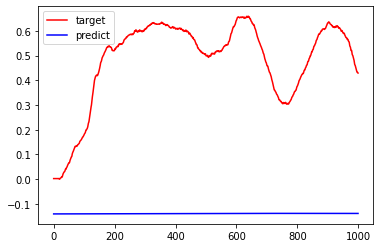

0 0.29925856


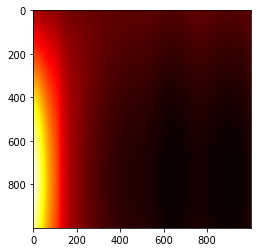

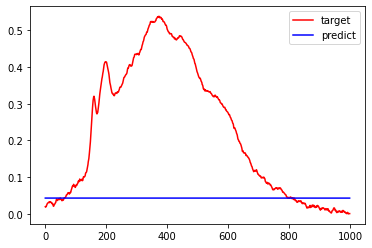

5 0.059745707


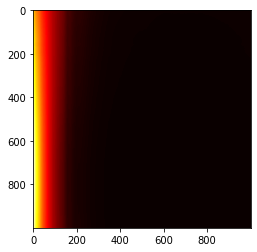

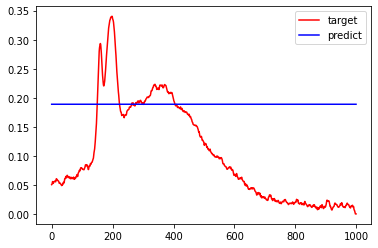

10 0.032306597


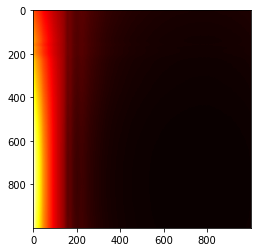

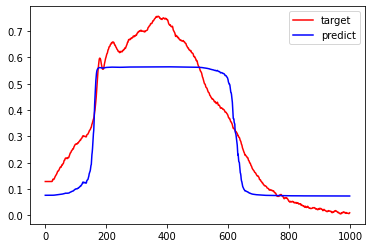

15 0.004738762


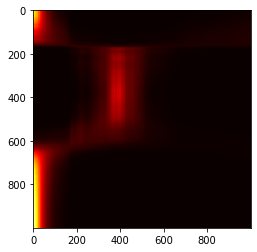

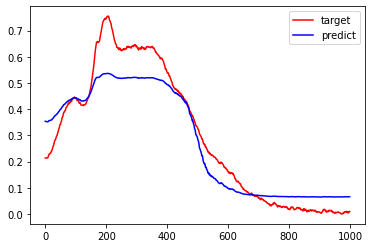

20 0.00398597


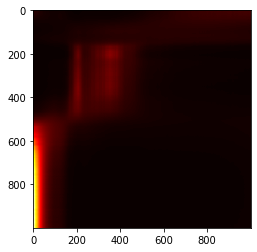

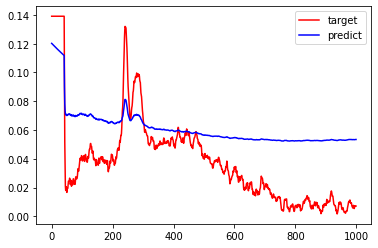

25 0.0030671298


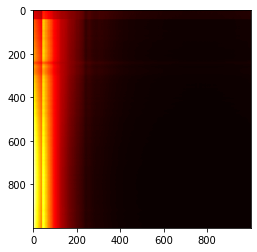

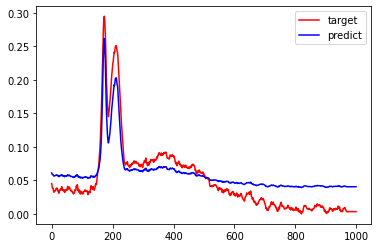

30 0.000931614


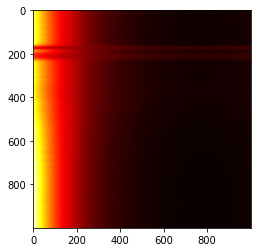

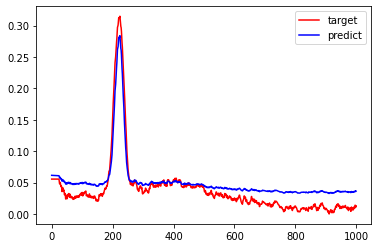

35 0.0006354028


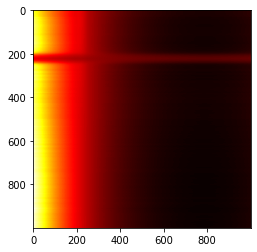

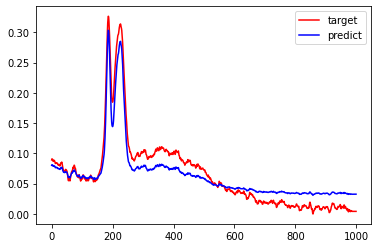

40 0.00044340448


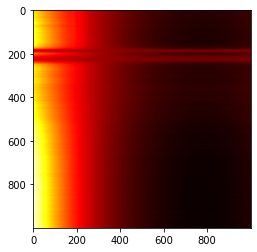

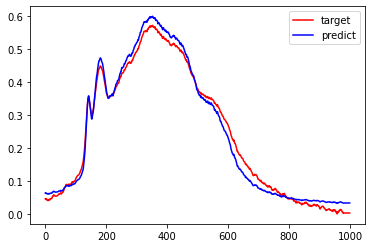

45 0.0004726102


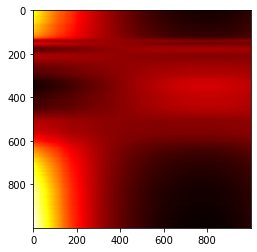

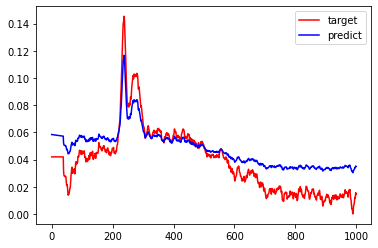

50 0.00036057903


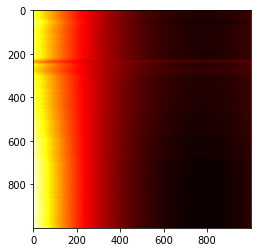

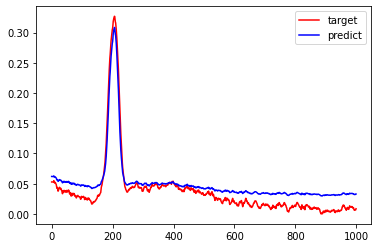

55 0.0003567673


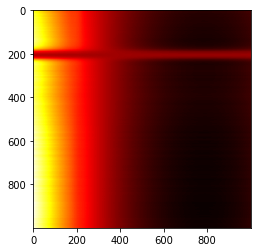

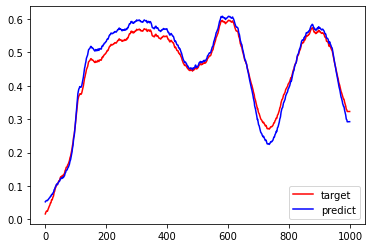

60 0.00040644433


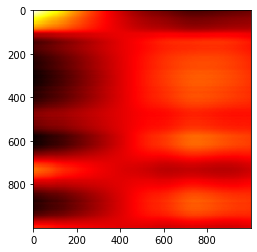

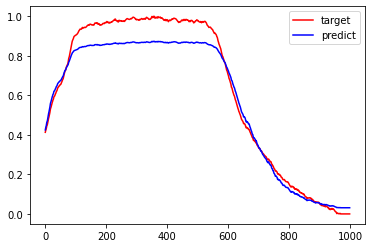

65 0.0017412328


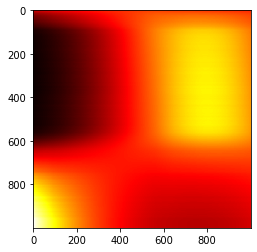

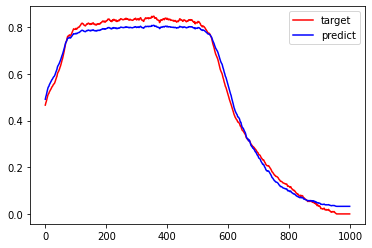

70 0.00041399722


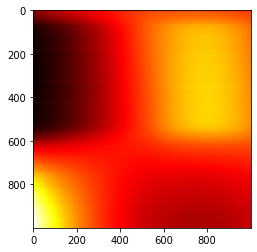

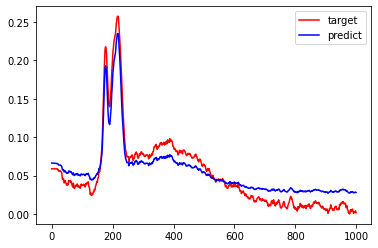

75 0.00030426777


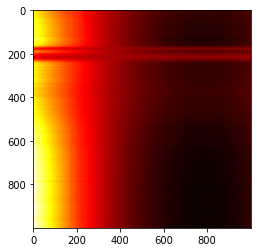

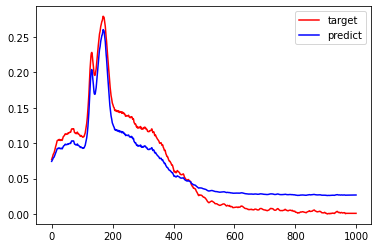

80 0.00030566886


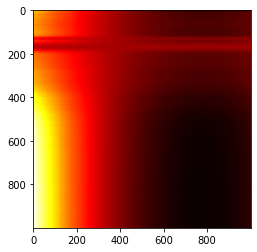

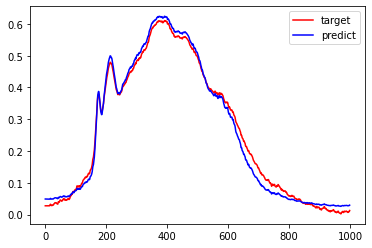

85 0.00040484418


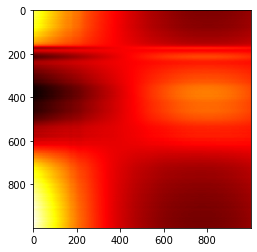

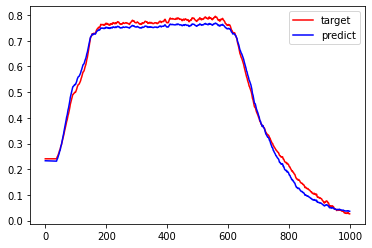

90 0.00030171205


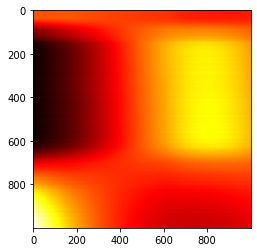

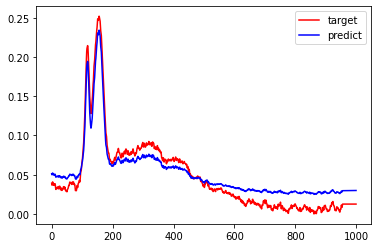

95 0.0002833025


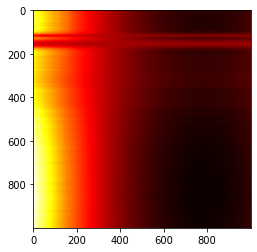

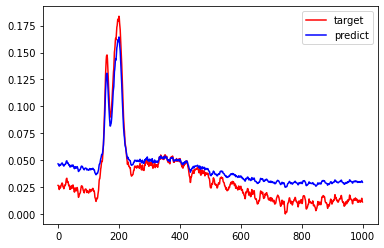

100 0.0002652974


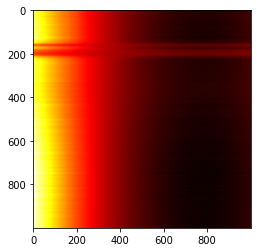

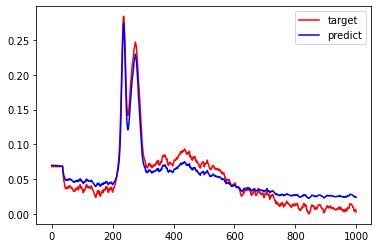

105 0.00021113282


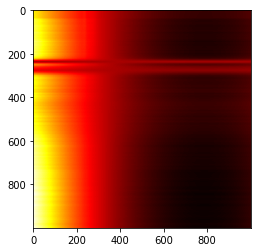

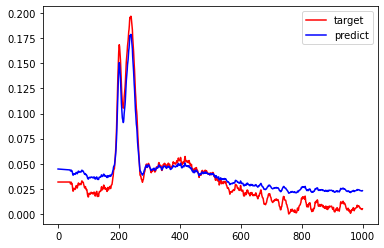

110 0.00016891836


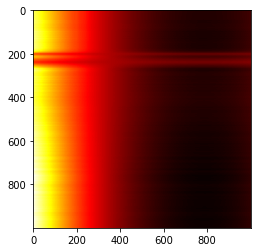

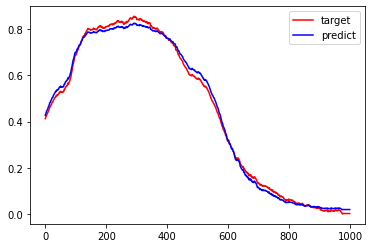

115 0.00047647886


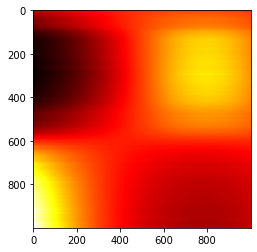

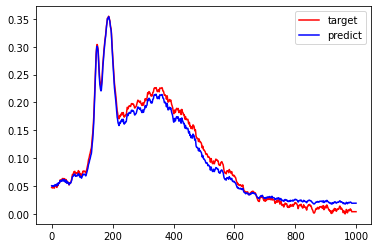

120 9.433574e-05


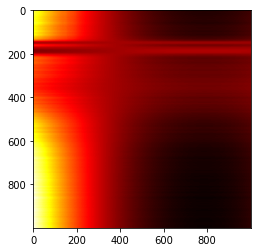

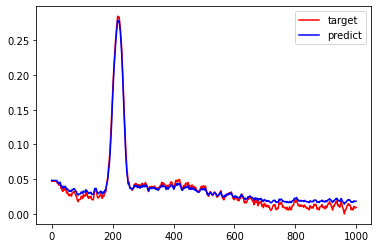

125 4.754993e-05


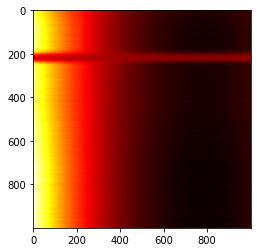

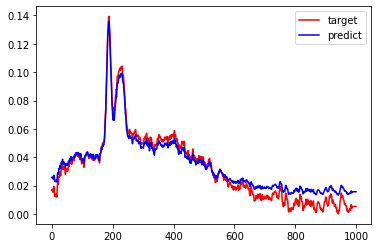

130 3.0405374e-05


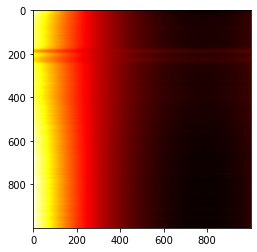

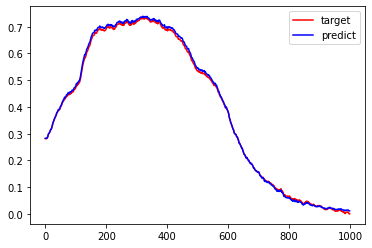

135 2.7512853e-05


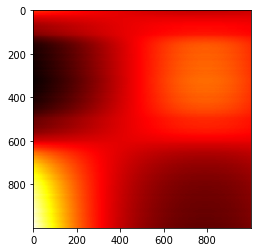

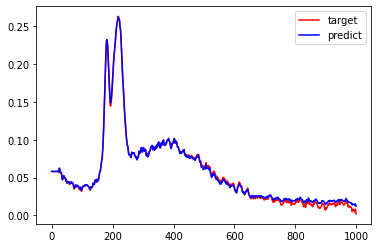

140 2.4527e-05


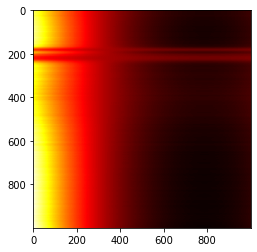

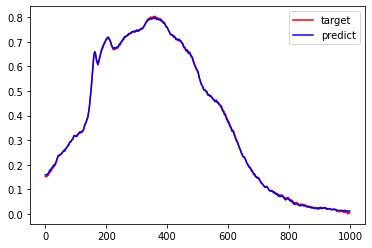

145 1.3742572e-05


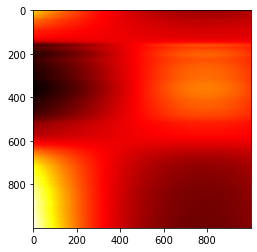

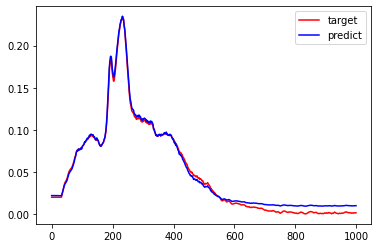

150 1.8784676e-05


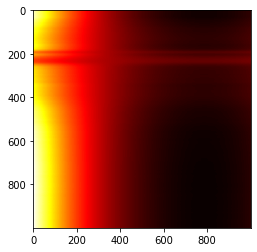

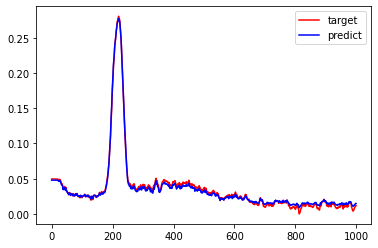

155 8.8642255e-06


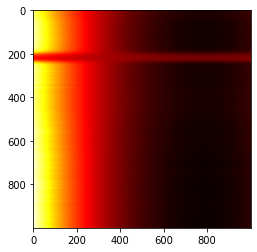

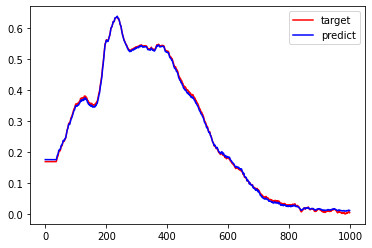

160 1.4568943e-05


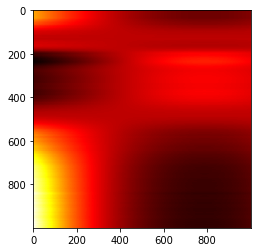

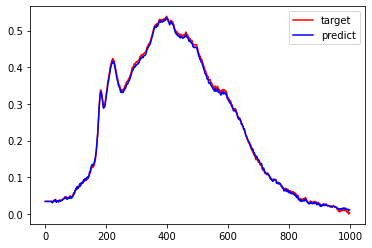

165 1.8627396e-05


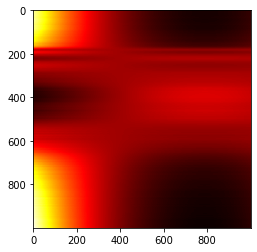

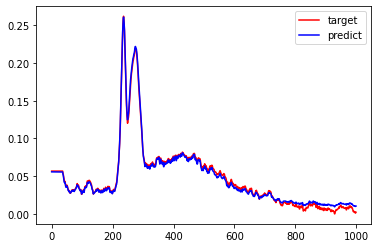

170 1.2001053e-05


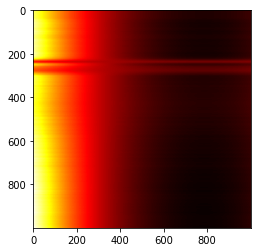

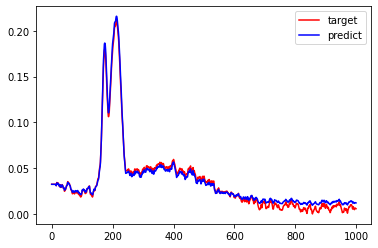

175 1.5586033e-05


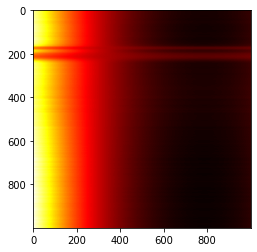

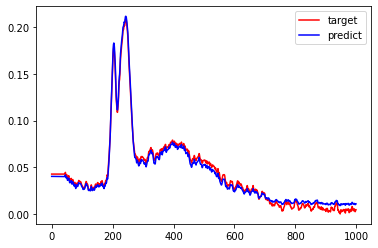

180 1.6386946e-05


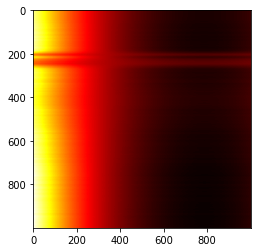

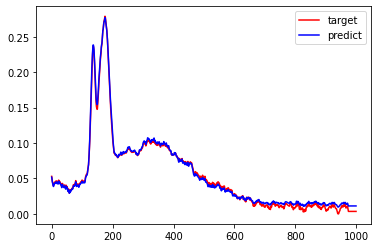

185 1.40681195e-05


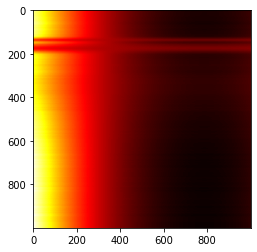

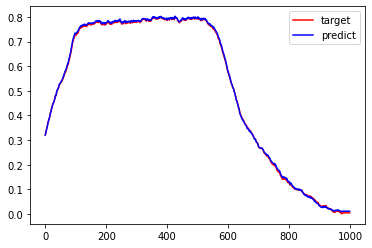

190 1.7020888e-05


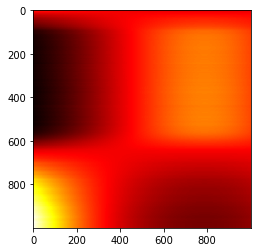

KeyboardInterrupt: 

In [102]:
epoch = int(1e4*10)
for it in range(epoch):
    for y_np_torch,y_np_target_torch in dataloader:
        predict,attentions = m(y_np_torch)
        # dbg('ok at it:', it)
        loss = loss_func(predict, y_np_target_torch)  # calculate loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

    if it % 5 == 0:
        plt.clf()  # Clear figure
        # print(predict)
        # dbg('a',attentions[0].cpu().data.numpy().sum(axis=0).max())
        # plt.plot(steps, y_np_target.flatten(), 'r-')
        # plt.plot(steps, predict.cpu().data.numpy().flatten(), 'b-', label=f'{it}')
        # dbg('attsum',(attentions[0].cpu().data.numpy().sum(axis=0)/1000.0).sum())
        # plt.plot( y_np_target[0].flatten(), 'r-',label='target')
        plt.plot( y_np_target_torch[0].cpu().data.numpy().flatten(), 'r-',label='target')
        plt.plot( predict[0].cpu().data.numpy().flatten(), 'b-', label=f'predict')
        # plt.plot( y_np[0].flatten(), 'g-',label='input')

        # plt.plot(attentions[0].cpu().data.numpy().sum(axis=0)/attentions[0].cpu().data.numpy().sum(axis=0).max(), 'y-', label=f'attention')
        # dbg('tar plt:',y_np_target_torch[0].cpu().data.numpy().flatten().shape)
        # dbg('pre plt:',predict[0].cpu().data.numpy().flatten().shape)

        # plt.ylim(-0.5, 0.5)

        plt.legend()
        plt.pause(0.05)

        dbg(it, loss.cpu().data.numpy(), force=True)

        plt.show()
        # time.sleep(1)

        # sample=2
        # dbg('row sum test',attentions[0,sample,:].cpu().data.numpy().sum())

        a=attentions[0,:,:]
        plt.imshow(a.cpu().data.numpy(), cmap='hot', interpolation='nearest')
        plt.show()

dbg('-' * 20, 'finish', '-' * 20)

In [19]:
# del m
# torch.cuda.empty_cache()
!nvidia-smi

Thu Apr 21 21:20:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.13       Driver Version: 496.13       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8     3W /  N/A |   1926MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
a=[[1,2],[4,3]]
sorted(a)

[1, 2, 3, 4]

In [2]:
a

[1, 2, 4, 3]